In [8]:
import kagglehub
path = kagglehub.dataset_download("shivamb/real-or-fake-fake-jobposting-prediction")
print(path)

/Users/596031367qq.com/.cache/kagglehub/datasets/shivamb/real-or-fake-fake-jobposting-prediction/versions/1


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Data Preprocessing 
1. Data Overview
    - 17880 rows, 18 columns
    - No Null Values
2. Target Variable
    - 0/1（0=real, 1=fake）
    - class imbalance Only 4.84% (866 jobs) are fraudulent. This confirms that we must use Stratified Split and Class Weights, as planned
3. Text construction
    - Fill NaN with empty strings 
    - Combine text columns by TF-IDF
    "title + company_profile + description + requirements + benefits"

In [10]:
df = pd.read_csv('/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 1. Data Preprocessing 
1. Data Overview
    - 17880 rows, 18 columns
    - No Null Values
2. Target Variable
    - 0/1（0=real, 1=fake）
    - class imbalance Only 4.84% (866 jobs) are fraudulent. This confirms that we must use Stratified Split and Class Weights, as planned
3. Text cleaning
    - Remove HTML tags, URLs, special characters, and extra whitespace
4. Text construction
    - Fill NaN with empty strings 
    - Combine text columns by TF-IDF
    "title + company_profile + description + requirements + benefits"


In [11]:
# 1.Data Overview
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

np.float64(0.04843400447427293)

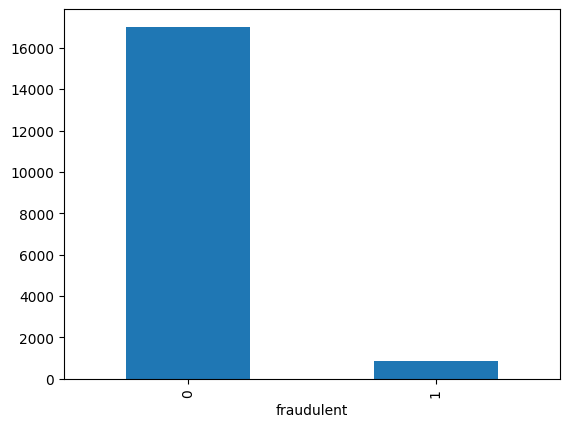

In [12]:
# 2. Imbalance Analysis
df['fraudulent'].value_counts().plot(kind='bar')
df['fraudulent'].mean()

In [13]:
# Null Value Analysis
df.isnull().sum().sort_values(ascending=False)

salary_range           15012
department             11547
required_education      8105
benefits                7212
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2696
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

#### Null Value Analysis
1. Text columns (title, company_profile, description, requirements, benefits) have some missing values.
	- title: 0
	- company_profile: 3308
	- description: 1
	- requirements: 2696
	- benefits: 7212
Solution:
- Use fill.na('') to fill the missing values with empty strings, and then combine the text columns into a single 'text' column for TF-IDF vectorization.
- add "has_company_profile" and "has_benefits" to improve model performance, as these may be strong indicators of job legitimacy.

2. Meta data columns have many missing values, so we can ignore them for now. For further analysis, we can explore if any of these meta data columns have predictive power by adding telecommuting / has_company_logo / has_questions

In [14]:
# 4. Text Construction
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_cols] = df[text_cols].fillna('')
df['text'] = df[text_cols].apply(lambda x: ' '.join(x), axis=1)

In [27]:
import re
# Text Cleaning
import re

def clean_text(text):
    # 1. lowercase
    text = str(text).lower()
    
    # 2. remove <br>, <div> and other HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 3. long URL patterns 
    text = re.sub(r'(?:#)?url_[a-z0-9]{15,}(?:#)?', ' ', text)
    
    # 4.remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    
    # 5. email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # 6. phone numbers 
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' ', text)
    
    # 7. punctuation removal
    text = re.sub(r'[^\w\s]', ' ', text) 
    
    # 8. extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['text'] = df['text'].apply(clean_text)

In [28]:
df['length'] = df['text'].apply(len)
df[['length', 'fraudulent']].groupby('fraudulent').describe()

length                                                           \
              count         mean          std   min     25%     50%      75%   
fraudulent                                                                     
0           17014.0  2574.685142  1389.078482  78.0  1573.0  2447.0  3349.75   
1             866.0  1969.879908  1462.140180  14.0   905.0  1577.0  2742.75   

                     
                max  
fraudulent           
0           14517.0  
1            9343.0

In [32]:
print(df['text'].head())

0    marketing intern were food52 and weve created ...
1    customer service cloud video production 90 sec...
2    commissioning machinery assistant cma valor se...
3    account executive washington dc our passion fo...
4    bill review manager spotsource solutions llc i...
Name: text, dtype: object


In [33]:
# Save the processed data for later use
df.to_csv('/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/fake_job_postings_processed.csv', index=False)